##### Попытки понять, как стеклянные шарики отражают свет.
Угол между падающим и отраженным лучом:
$$\gamma = 2(2\beta - \alpha) = 2(2\arcsin\frac{r}{n_2} - \arcsin\frac{r}{n_1})$$
$n_1$ - показатель преломления среды, **откуда** луч пришел, $n_2$ - соответственно, **куда**.
поскольку луч падает из воздуха, $n_1=1$

$\alpha$ - угол падения, $\beta$ - угол преломления. 
$$n_1\sin\alpha = n_2\sin\beta$$

![angles](2.png)

При достаточно большом коэффициенте преломления и попадании луча ближе к краю шарика угол $\gamma$ может стать
отрицательным, то есть луч отклонится в ту же сторону от середины шарика, в которую попал.
Так что имеет смысл брать модуль угла.

![negative gamma](3.png)

На границе сред луч не только проходит с преломлением в другую среду, но и частично отражается.  
Формулы Френеля для амплитуд отраженного и прошедшего луча:
 * перпендикулярно к плоскости падения поляризованный луч
   - отражение $$\rho_s = \frac{\sin^2(\alpha - \beta)}{\sin^2(\alpha + \beta)}$$
   - прохождение $$\tau_s = \frac{\sin^2\alpha +\sin(\alpha - \beta)}{\sin^2(\alpha + \beta)}$$
 * параллельно к плоскости падения поляризованный луч
   - отражение $$\DeclareMathOperator{\tg}{tg} \rho_p = \frac{\tg^2(\alpha - \beta)}{\tg^2(\alpha + \beta)}$$
   - прохождение $$\tau_p = \frac{\sin^2\alpha +\sin(\alpha - \beta)}
                                 {\sin^2(\alpha + \beta)\cos^2(\alpha - \beta)}$$
               
При прохождении луча из стекла в воздух $\beta \gt \alpha$,
когда $\beta \ge \frac{\pi}{2}\ (90^\circ)$ отражение становится полным, но в случае шарика это недостижимо - под каким углом
зашел, под таким и выйдет, а войти под 90$^\circ$ не получится.

При $\alpha = \beta = 0$
$$\rho = \left(\frac{n_2 - n_1}{n_2 + n_1}\right)^2$$

$$\tau = \frac{4 n_2 n_1}{(n_2 + n_1)^2}$$

Формулы Френеля взял с [https://de.ifmo.ru/bk_netra/start.php?bn=201](https://de.ifmo.ru/bk_netra/start.php?bn=201),
надеюсь ничего не напутал.

P.S.  Для коэффициентов прохождения при ненулевом угле в источнике какая-то ерунда написана.  Так и не понял, как они вывели (3.2.14), а при попытке расчета значения явно неправильные.  Лучше использовать только коэффициенты отражения, учитывая, что из закона сохранения энергии $\tau=1-\rho$.  А еще институт оптики!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 10000  # Сколько лучей будем обсчитывать
I0 = 1000   # Начальная интенсивность падающего света

r = np.linspace(0, 1, N + 1)

In [3]:

def compute_I_gamma(n1, n2):

    np.seterr(invalid='ignore')
    def rho_s(alpha, beta):
        return np.where(alpha == 0, ((n2 - n1)/(n2 + n1))**2,
                        np.sin(alpha - beta)**2 / np.sin(alpha + beta)**2
                       )

    def rho_p(alpha, beta):
        return np.where(alpha == 0, ((n2 - n1)/(n2 + n1))**2,
                        np.tan(alpha - beta)**2 / np.tan(alpha + beta)**2
                       )
    
    I = I0/N    # начальная интенсивность каждого луча

    alpha = np.arcsin(r)
    beta = np.arcsin(r*n1/n2)
    gamma = np.abs(2*(2*beta - alpha))
    
    #Луч входит в шарик.  Нас интересует прошедший внутрь. Компоненты с разной поляризацией считаем отдельно.
    Is = 1/2 * I * (1 - rho_s(alpha, beta))
    Ip = 1/2 * I * (1 - rho_p(alpha, beta))

    # Внутреннее отражение.  Интересует энергия _отраженного изнутри_ луча.
    Is = Is * rho_s(alpha, beta)
    Ip = Ip * rho_p(alpha, beta)

    # Выход наружу.
    Is = Is * (1 - rho_s(alpha, beta))
    Ip = Ip * (1 - rho_p(alpha, beta))

    # Сложили компоненты с разной поляризацией в окончательную интенсивность луча.
    I = Is + Ip

    # Смотрим каждый градус и суммируем интенсивности попавших в них лучей
    angles = np.linspace(0, np.pi/2, 301)
    I_gamma = [I[(gamma >= b)&(gamma < e)].sum() for b,e in zip(angles[:-1], angles[1:])]
    
    return angles[:-1], I_gamma

Суммарная интенсивность, отраженная в более-менее обратном направлении, всего лишь пять с половиной процентов при коэффициенте преломления 1.6, при n=2 - восемь с половиной процентов. Большая часть проходит шарик насквозь. При бОльших n отражение растет, но диаграмма уже не острая.

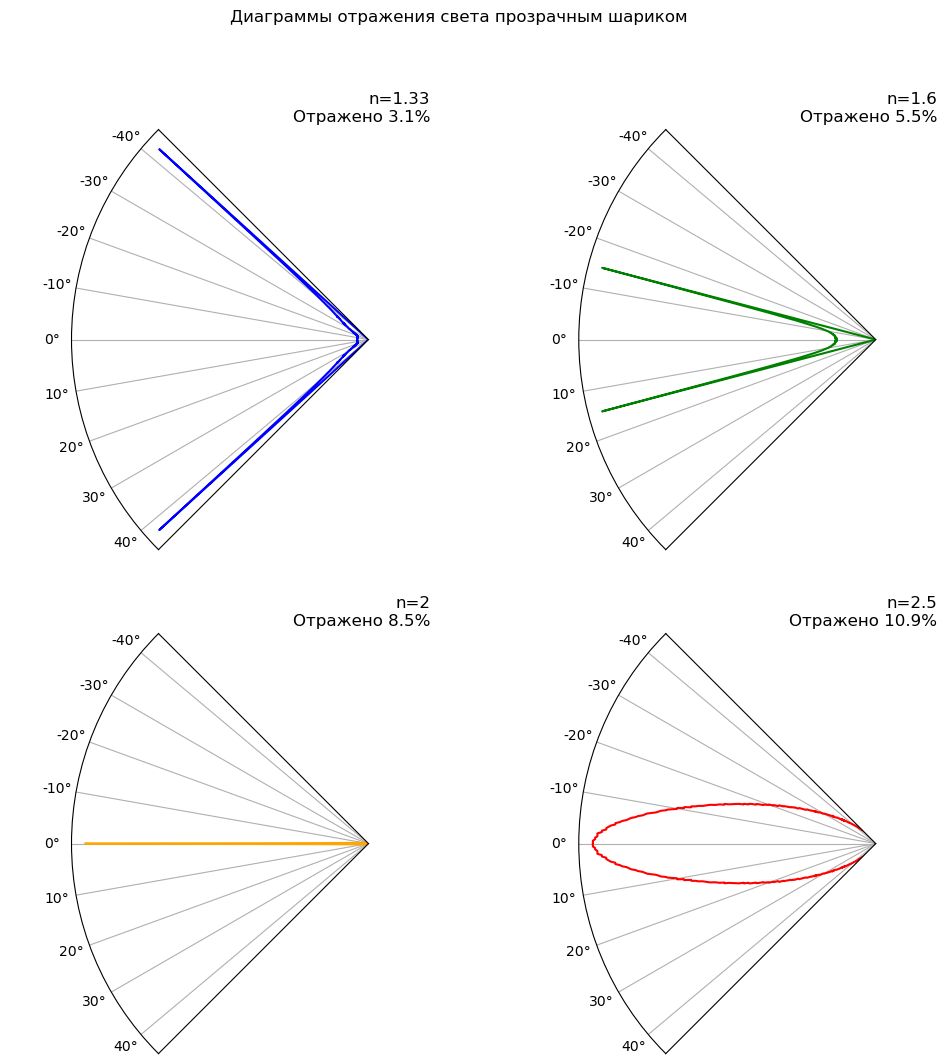

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='polar'))
for ax in axs.ravel():
    ax.set_xlim=(-45, 45)
    ax.set_thetamin(-45)
    ax.set_thetamax(45)
    ax.set_theta_offset(np.pi)
    ax.yaxis.set_visible(False)

colors = ('blue', 'green', 'orange', 'red')
for i, n2 in enumerate((1.33, 1.6, 2, 2.5)):
    angles, I_gamma = compute_I_gamma(1, n2)
    ax = axs.ravel()[i]
    ax.plot(angles, I_gamma, color=colors[i])
    ax.plot(-angles, I_gamma, color=colors[i])
    p = sum(I_gamma)/I0*100
    ax.set_title(f'n={n2}\nОтражено {p:.1f}%', loc='right')
fig.suptitle("Диаграммы отражения света прозрачным шариком");